# Netflix Content Classificatie Model

---

## Voorspellen: Movie of TV Show?

**Onderzoeksvraag:** *Kunnen we op basis van kenmerken zoals genre, rating, land van herkomst en release jaar voorspellen of nieuwe content een Film of TV Show wordt?*

---

### Model Approach (CRISP-DM)
1. **Data Preparation** - Feature engineering voor machine learning
2. **Modeling** - Train een classificatie model
3. **Evaluation** - Beoordeel model prestaties
4. **Visualisatie** - Presenteer resultaten helder en begrijpelijk

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)

# Plotly voor interactieve visualisaties
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Netflix kleuren
NETFLIX_RED = '#E50914'
NETFLIX_BLACK = '#141414'

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("Libraries geladen!")

Libraries geladen!


---
## 1. Data Laden & Feature Engineering

In [2]:
# Laad data
df = pd.read_csv('netflix_titles.csv')
print(f"Dataset geladen: {len(df)} titels")
print(f"Movies: {len(df[df['type'] == 'Movie'])} | TV Shows: {len(df[df['type'] == 'TV Show'])}")

Dataset geladen: 8807 titels
Movies: 6131 | TV Shows: 2676


In [3]:
# Feature Engineering
df_model = df.copy()

# 1. Target variable: type (Movie = 0, TV Show = 1)
df_model['target'] = (df_model['type'] == 'TV Show').astype(int)

# 2. Release year als feature
df_model['release_year_scaled'] = df_model['release_year']

# 3. Aantal genres
df_model['genre_count'] = df_model['listed_in'].apply(lambda x: len(x.split(', ')))

# 4. Primary country extraction
df_model['country_filled'] = df_model['country'].fillna('Unknown')
df_model['primary_country'] = df_model['country_filled'].apply(lambda x: x.split(', ')[0])

# 5. Is US content?
df_model['is_us'] = (df_model['primary_country'] == 'United States').astype(int)

# 6. Rating categories
rating_categories = {
    'Kids': ['TV-Y', 'TV-Y7', 'TV-Y7-FV', 'G', 'TV-G', 'PG'],
    'Teens': ['PG-13', 'TV-PG', 'TV-14'],
    'Adults': ['R', 'TV-MA', 'NC-17', 'NR', 'UR']
}

def categorize_rating(rating):
    for category, ratings in rating_categories.items():
        if rating in ratings:
            return category
    return 'Unknown'

df_model['rating_category'] = df_model['rating'].apply(categorize_rating)

# 7. One-hot encode rating category
rating_dummies = pd.get_dummies(df_model['rating_category'], prefix='rating')
df_model = pd.concat([df_model, rating_dummies], axis=1)

# 8. Genre features (top genres als binary features)
top_genres = ['International TV Shows', 'Dramas', 'Comedies', 'Action & Adventure', 
              'Documentaries', 'Children & Family Movies', 'Stand-Up Comedy']

for genre in top_genres:
    col_name = 'genre_' + genre.replace(' ', '_').replace('&', 'and').lower()
    df_model[col_name] = df_model['listed_in'].apply(lambda x: 1 if genre in x else 0)

# 9. Has director info?
df_model['has_director'] = df_model['director'].notna().astype(int)

# 10. Description length
df_model['desc_length'] = df_model['description'].apply(lambda x: len(str(x)))

print("\nFeature Engineering voltooid!")
print(f"Nieuwe features: {df_model.shape[1] - df.shape[1]}")


Feature Engineering voltooid!
Nieuwe features: 20


In [4]:
# Selecteer features voor model
feature_columns = [
    'release_year_scaled',
    'genre_count',
    'is_us',
    'rating_Adults', 'rating_Kids', 'rating_Teens', 'rating_Unknown',
    'genre_international_tv_shows',
    'genre_dramas',
    'genre_comedies',
    'genre_action_and_adventure',
    'genre_documentaries',
    'genre_children_and_family_movies',
    'genre_stand-up_comedy',
    'has_director',
    'desc_length'
]

# Verwijder rijen met missende waarden in features
df_model_clean = df_model.dropna(subset=['rating'])

X = df_model_clean[feature_columns]
y = df_model_clean['target']

print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(f"  - Movies (0): {(y == 0).sum()} ({(y == 0).mean()*100:.1f}%)")
print(f"  - TV Shows (1): {(y == 1).sum()} ({(y == 1).mean()*100:.1f}%)")

Features shape: (8803, 16)
Target distribution:
  - Movies (0): 6129 (69.6%)
  - TV Shows (1): 2674 (30.4%)


---
## 2. Model Training

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: 7042 samples
Test set: 1761 samples


In [6]:
# Train Random Forest Model
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# Cross-validation
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

Training Random Forest Classifier...



Cross-validation scores: [0.9815472  0.97941803 0.97443182 0.97159091 0.98295455]
Mean CV Accuracy: 0.9780 (+/- 0.0086)


In [7]:
# Train Logistic Regression voor vergelijking
print("Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5)
print(f"Mean CV Accuracy (LR): {cv_scores_lr.mean():.4f}")

Training Logistic Regression...
Mean CV Accuracy (LR): 0.9760


---
## 3. Model Evaluatie

In [8]:
# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Accuracy comparison
print("="*60)
print("MODEL PERFORMANCE VERGELIJKING")
print("="*60)
print(f"\nRandom Forest Accuracy:     {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")

MODEL PERFORMANCE VERGELIJKING

Random Forest Accuracy:     0.9841
Logistic Regression Accuracy: 0.9835


In [9]:
# Detailed classification report
print("\n" + "="*60)
print("RANDOM FOREST - GEDETAILLEERD RAPPORT")
print("="*60)
print(classification_report(y_test, y_pred_rf, target_names=['Movie', 'TV Show']))


RANDOM FOREST - GEDETAILLEERD RAPPORT
              precision    recall  f1-score   support

       Movie       0.99      0.99      0.99      1226
     TV Show       0.97      0.97      0.97       535

    accuracy                           0.98      1761
   macro avg       0.98      0.98      0.98      1761
weighted avg       0.98      0.98      0.98      1761



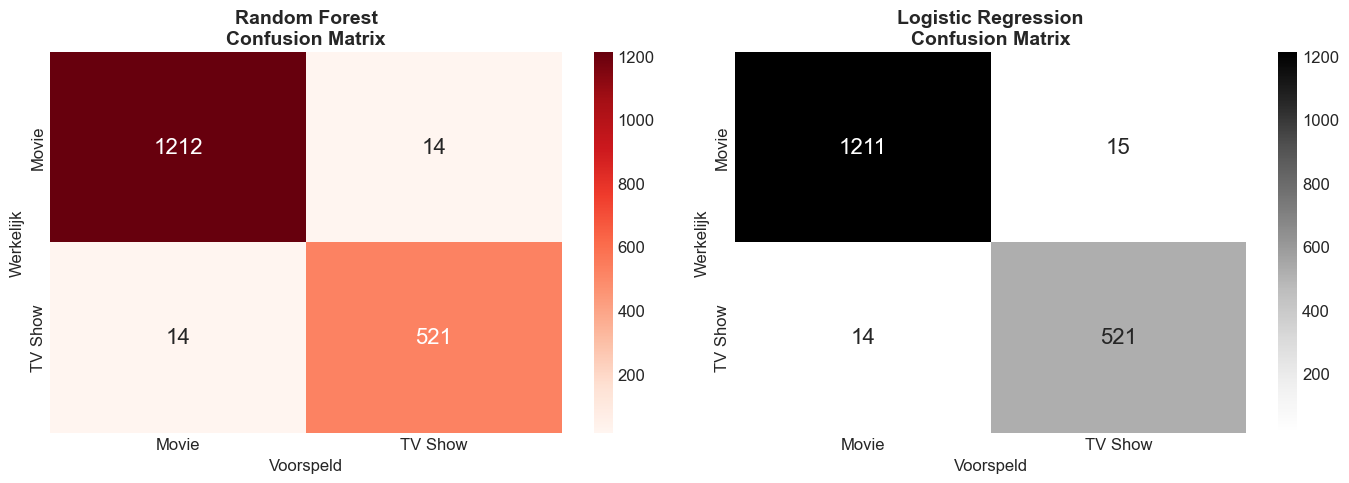


Random Forest Details:
  True Negatives (Correct Movies): 1212
  True Positives (Correct TV Shows): 521
  False Positives (Movies als TV Show): 14
  False Negatives (TV Shows als Movie): 14


In [10]:
# Confusion Matrix Visualisatie
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=['Movie', 'TV Show'], yticklabels=['Movie', 'TV Show'],
            annot_kws={'size': 16})
axes[0].set_title('Random Forest\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Voorspeld', fontsize=12)
axes[0].set_ylabel('Werkelijk', fontsize=12)

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greys', ax=axes[1],
            xticklabels=['Movie', 'TV Show'], yticklabels=['Movie', 'TV Show'],
            annot_kws={'size': 16})
axes[1].set_title('Logistic Regression\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Voorspeld', fontsize=12)
axes[1].set_ylabel('Werkelijk', fontsize=12)

plt.tight_layout()
plt.savefig('model_01_confusion_matrix.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm_rf.ravel()
print(f"\nRandom Forest Details:")
print(f"  True Negatives (Correct Movies): {tn}")
print(f"  True Positives (Correct TV Shows): {tp}")
print(f"  False Positives (Movies als TV Show): {fp}")
print(f"  False Negatives (TV Shows als Movie): {fn}")

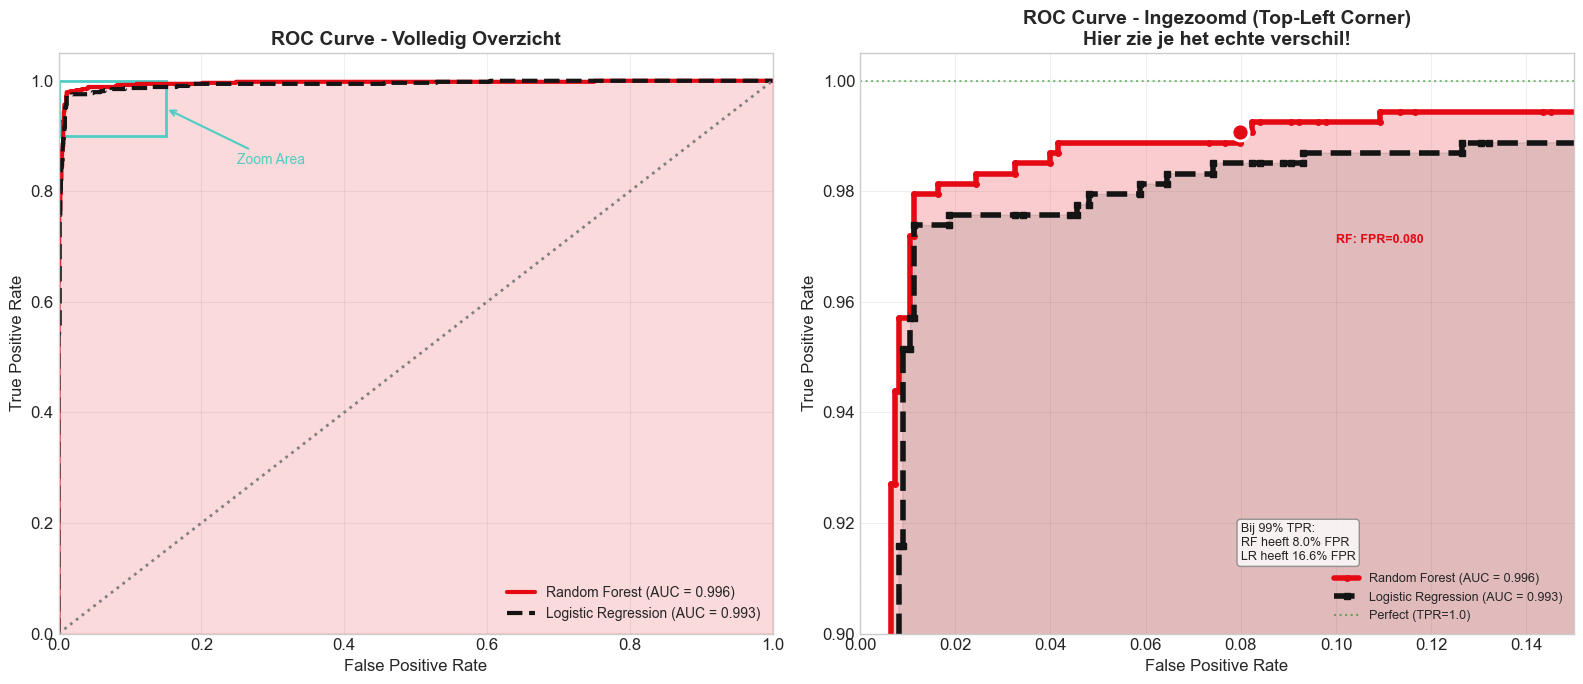


AUC Scores:
  Random Forest: 0.9956
  Logistic Regression: 0.9934

De ingezoomde view toont het verschil in de kritieke linkerbovenhoek!


In [11]:
# ROC Curve Vergelijking - Met Ingezoomde View
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# === LEFT PLOT: Full ROC Curve ===
ax1 = axes[0]
ax1.plot(fpr_rf, tpr_rf, color=NETFLIX_RED, lw=3, 
        label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
ax1.plot(fpr_lr, tpr_lr, color=NETFLIX_BLACK, lw=3, linestyle='--',
        label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')
ax1.plot([0, 1], [0, 1], color='gray', lw=2, linestyle=':')
ax1.fill_between(fpr_rf, tpr_rf, alpha=0.15, color=NETFLIX_RED)

# Highlight zoom area
from matplotlib.patches import Rectangle
rect = Rectangle((0, 0.9), 0.15, 0.1, linewidth=2, edgecolor='#4ECDC4', facecolor='none', linestyle='-')
ax1.add_patch(rect)
ax1.annotate('Zoom Area', xy=(0.15, 0.95), xytext=(0.25, 0.85),
            fontsize=10, color='#4ECDC4',
            arrowprops=dict(arrowstyle='->', color='#4ECDC4', lw=1.5))

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve - Volledig Overzicht', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)

# === RIGHT PLOT: Zoomed ROC Curve (Critical Region) ===
ax2 = axes[1]
ax2.plot(fpr_rf, tpr_rf, color=NETFLIX_RED, lw=4, marker='o', markersize=4,
        label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
ax2.plot(fpr_lr, tpr_lr, color=NETFLIX_BLACK, lw=4, linestyle='--', marker='s', markersize=4,
        label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')

# Fill between to show difference
ax2.fill_between(fpr_rf, tpr_rf, alpha=0.2, color=NETFLIX_RED)
ax2.fill_between(fpr_lr, tpr_lr, alpha=0.1, color=NETFLIX_BLACK)

# Zoom into top-left corner where the action is
ax2.set_xlim([0.0, 0.15])
ax2.set_ylim([0.90, 1.005])

# Add reference lines
ax2.axhline(y=1.0, color='green', linestyle=':', alpha=0.5, label='Perfect (TPR=1.0)')
ax2.axvline(x=0.0, color='green', linestyle=':', alpha=0.5)

# Annotate key points
# Find the point where TPR first reaches ~0.99 for each model
rf_99_idx = np.argmax(tpr_rf >= 0.99)
lr_99_idx = np.argmax(tpr_lr >= 0.99)

if rf_99_idx > 0:
    ax2.scatter([fpr_rf[rf_99_idx]], [tpr_rf[rf_99_idx]], color=NETFLIX_RED, s=150, zorder=5, edgecolor='white', linewidth=2)
    ax2.annotate(f'RF: FPR={fpr_rf[rf_99_idx]:.3f}', 
                xy=(fpr_rf[rf_99_idx], tpr_rf[rf_99_idx]), 
                xytext=(fpr_rf[rf_99_idx]+0.02, tpr_rf[rf_99_idx]-0.02),
                fontsize=9, color=NETFLIX_RED, fontweight='bold')

if lr_99_idx > 0:
    ax2.scatter([fpr_lr[lr_99_idx]], [tpr_lr[lr_99_idx]], color=NETFLIX_BLACK, s=150, zorder=5, marker='s', edgecolor='white', linewidth=2)
    ax2.annotate(f'LR: FPR={fpr_lr[lr_99_idx]:.3f}', 
                xy=(fpr_lr[lr_99_idx], tpr_lr[lr_99_idx]), 
                xytext=(fpr_lr[lr_99_idx]+0.02, tpr_lr[lr_99_idx]-0.03),
                fontsize=9, color=NETFLIX_BLACK, fontweight='bold')

ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curve - Ingezoomd (Top-Left Corner)\nHier zie je het echte verschil!', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3)

# Add insight text box
textstr = f'Bij 99% TPR:\nRF heeft {fpr_rf[rf_99_idx]*100:.1f}% FPR\nLR heeft {fpr_lr[lr_99_idx]*100:.1f}% FPR'
props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
ax2.text(0.08, 0.92, textstr, fontsize=9, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('model_02_roc_curve.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nAUC Scores:")
print(f"  Random Forest: {roc_auc_rf:.4f}")
print(f"  Logistic Regression: {roc_auc_lr:.4f}")
print(f"\nDe ingezoomde view toont het verschil in de kritieke linkerbovenhoek!")

---
## 4. Feature Importance: Wat Bepaalt het Verschil?

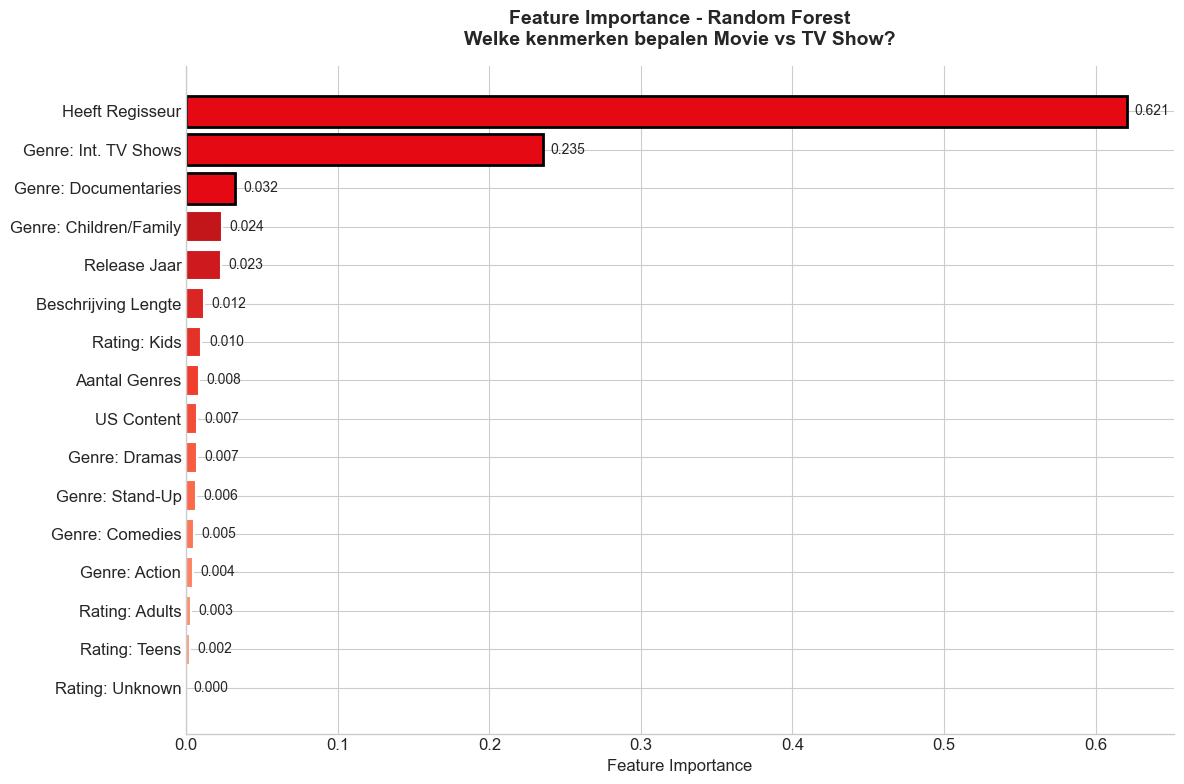


Top 5 Belangrijkste Features:
  Heeft Regisseur: 0.6207
  Genre: Int. TV Shows: 0.2354
  Genre: Documentaries: 0.0324
  Genre: Children/Family: 0.0236
  Release Jaar: 0.0231


In [12]:
# Feature Importance van Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

# Maak mooiere labels
label_mapping = {
    'release_year_scaled': 'Release Jaar',
    'genre_count': 'Aantal Genres',
    'is_us': 'US Content',
    'rating_Adults': 'Rating: Adults',
    'rating_Kids': 'Rating: Kids',
    'rating_Teens': 'Rating: Teens',
    'rating_Unknown': 'Rating: Unknown',
    'genre_international_tv_shows': 'Genre: Int. TV Shows',
    'genre_dramas': 'Genre: Dramas',
    'genre_comedies': 'Genre: Comedies',
    'genre_action_and_adventure': 'Genre: Action',
    'genre_documentaries': 'Genre: Documentaries',
    'genre_children_and_family_movies': 'Genre: Children/Family',
    'genre_stand-up_comedy': 'Genre: Stand-Up',
    'has_director': 'Heeft Regisseur',
    'desc_length': 'Beschrijving Lengte'
}

feature_importance['label'] = feature_importance['feature'].map(label_mapping)

# Visualisatie
fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(feature_importance)))
bars = ax.barh(feature_importance['label'], feature_importance['importance'], 
               color=colors, edgecolor='white', linewidth=1.5)

# Highlight top 3
for i, bar in enumerate(bars[-3:]):
    bar.set_color(NETFLIX_RED)
    bar.set_edgecolor('black')
    bar.set_linewidth(2)

# Voeg waarden toe
for bar, imp in zip(bars, feature_importance['importance']):
    ax.text(imp + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{imp:.3f}', va='center', fontsize=10)

ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Feature Importance - Random Forest\nWelke kenmerken bepalen Movie vs TV Show?', 
             fontsize=14, fontweight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('model_03_feature_importance.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nTop 5 Belangrijkste Features:")
for i, row in feature_importance.tail(5).iloc[::-1].iterrows():
    print(f"  {row['label']}: {row['importance']:.4f}")

In [13]:
# Interactieve Feature Importance met Plotly
fig = px.bar(
    feature_importance.tail(10),
    x='importance',
    y='label',
    orientation='h',
    color='importance',
    color_continuous_scale=['#FFE5E5', '#FF9999', '#FF3333', NETFLIX_RED],
    title='<b>Top 10 Belangrijkste Features</b>'
)

fig.update_layout(
    xaxis_title='Feature Importance',
    yaxis_title='',
    height=500,
    showlegend=False
)

fig.show()

---
## 5. Model Interpretatie & Conclusies

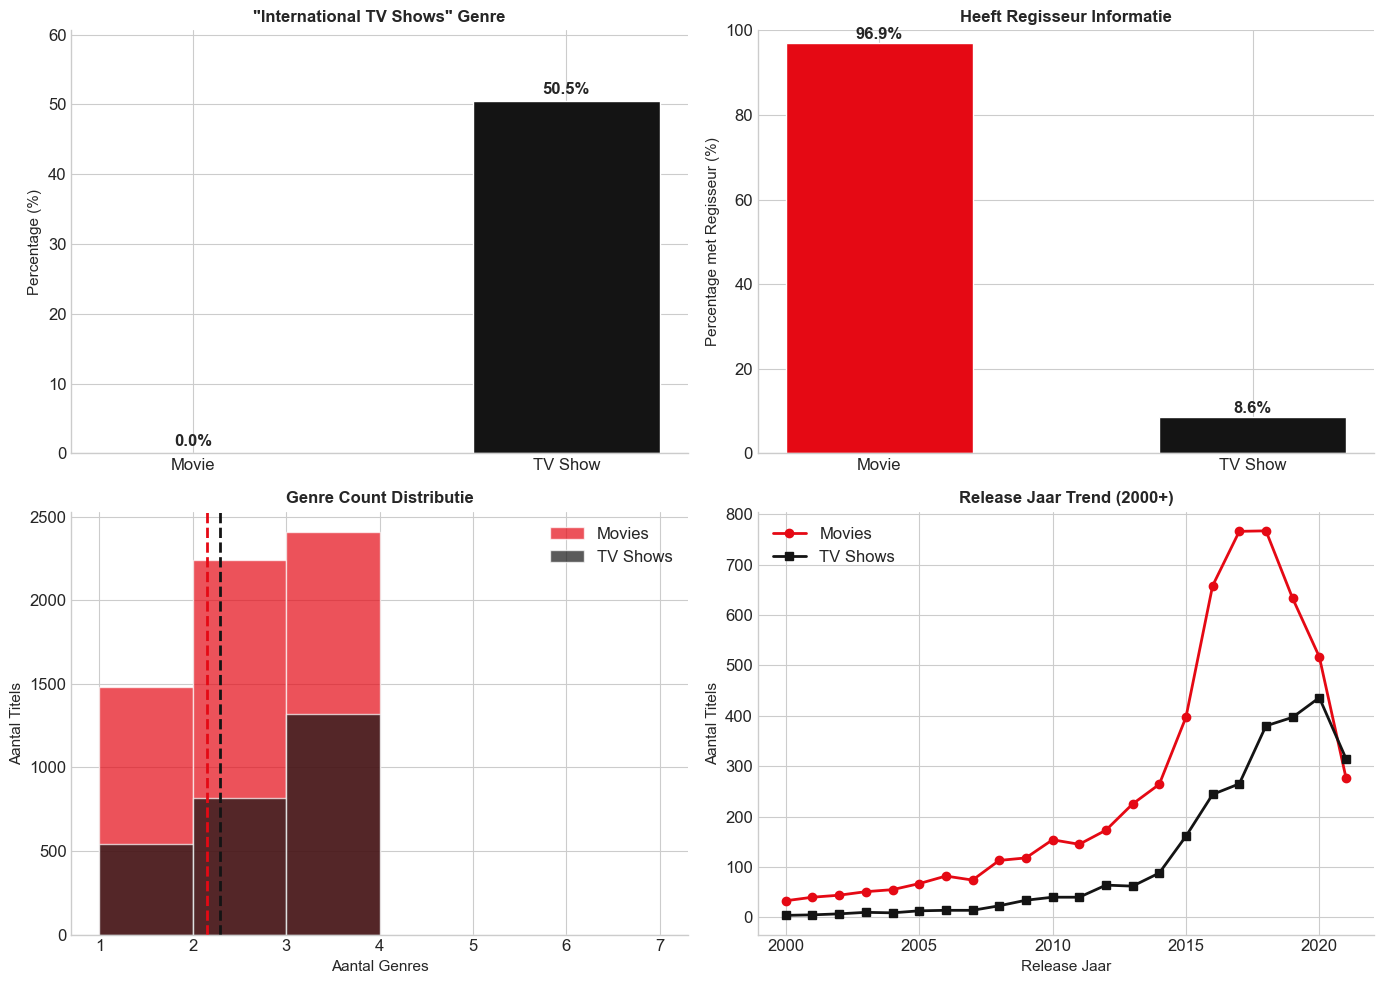

In [14]:
# Analyse: Hoe verschillen Movies en TV Shows op basis van top features?
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. International TV Shows genre
ax1 = axes[0, 0]
int_tv_by_type = df_model_clean.groupby('type')['genre_international_tv_shows'].mean() * 100
colors = [NETFLIX_RED, NETFLIX_BLACK]
bars = ax1.bar(int_tv_by_type.index, int_tv_by_type.values, color=colors, edgecolor='white', width=0.5)
for bar, val in zip(bars, int_tv_by_type.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.1f}%', ha='center', fontsize=12, fontweight='bold')
ax1.set_ylabel('Percentage (%)', fontsize=11)
ax1.set_title('"International TV Shows" Genre', fontsize=12, fontweight='bold')
ax1.set_ylim(0, max(int_tv_by_type.values) * 1.2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 2. Has Director
ax2 = axes[0, 1]
director_by_type = df_model_clean.groupby('type')['has_director'].mean() * 100
bars = ax2.bar(director_by_type.index, director_by_type.values, color=colors, edgecolor='white', width=0.5)
for bar, val in zip(bars, director_by_type.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.1f}%', ha='center', fontsize=12, fontweight='bold')
ax2.set_ylabel('Percentage met Regisseur (%)', fontsize=11)
ax2.set_title('Heeft Regisseur Informatie', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 100)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# 3. Genre Count Distribution
ax3 = axes[1, 0]
movies_genres = df_model_clean[df_model_clean['type'] == 'Movie']['genre_count']
tv_genres = df_model_clean[df_model_clean['type'] == 'TV Show']['genre_count']
ax3.hist(movies_genres, bins=range(1, 8), alpha=0.7, label='Movies', color=NETFLIX_RED, edgecolor='white')
ax3.hist(tv_genres, bins=range(1, 8), alpha=0.7, label='TV Shows', color=NETFLIX_BLACK, edgecolor='white')
ax3.axvline(movies_genres.mean(), color=NETFLIX_RED, linestyle='--', linewidth=2)
ax3.axvline(tv_genres.mean(), color=NETFLIX_BLACK, linestyle='--', linewidth=2)
ax3.set_xlabel('Aantal Genres', fontsize=11)
ax3.set_ylabel('Aantal Titels', fontsize=11)
ax3.set_title('Genre Count Distributie', fontsize=12, fontweight='bold')
ax3.legend()
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# 4. Release Year Trend
ax4 = axes[1, 1]
yearly_type = df_model_clean.groupby(['release_year', 'type']).size().unstack(fill_value=0)
yearly_type = yearly_type[yearly_type.index >= 2000]  # Focus on 2000+
ax4.plot(yearly_type.index, yearly_type['Movie'], color=NETFLIX_RED, linewidth=2, marker='o', label='Movies')
ax4.plot(yearly_type.index, yearly_type['TV Show'], color=NETFLIX_BLACK, linewidth=2, marker='s', label='TV Shows')
ax4.set_xlabel('Release Jaar', fontsize=11)
ax4.set_ylabel('Aantal Titels', fontsize=11)
ax4.set_title('Release Jaar Trend (2000+)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('model_04_feature_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

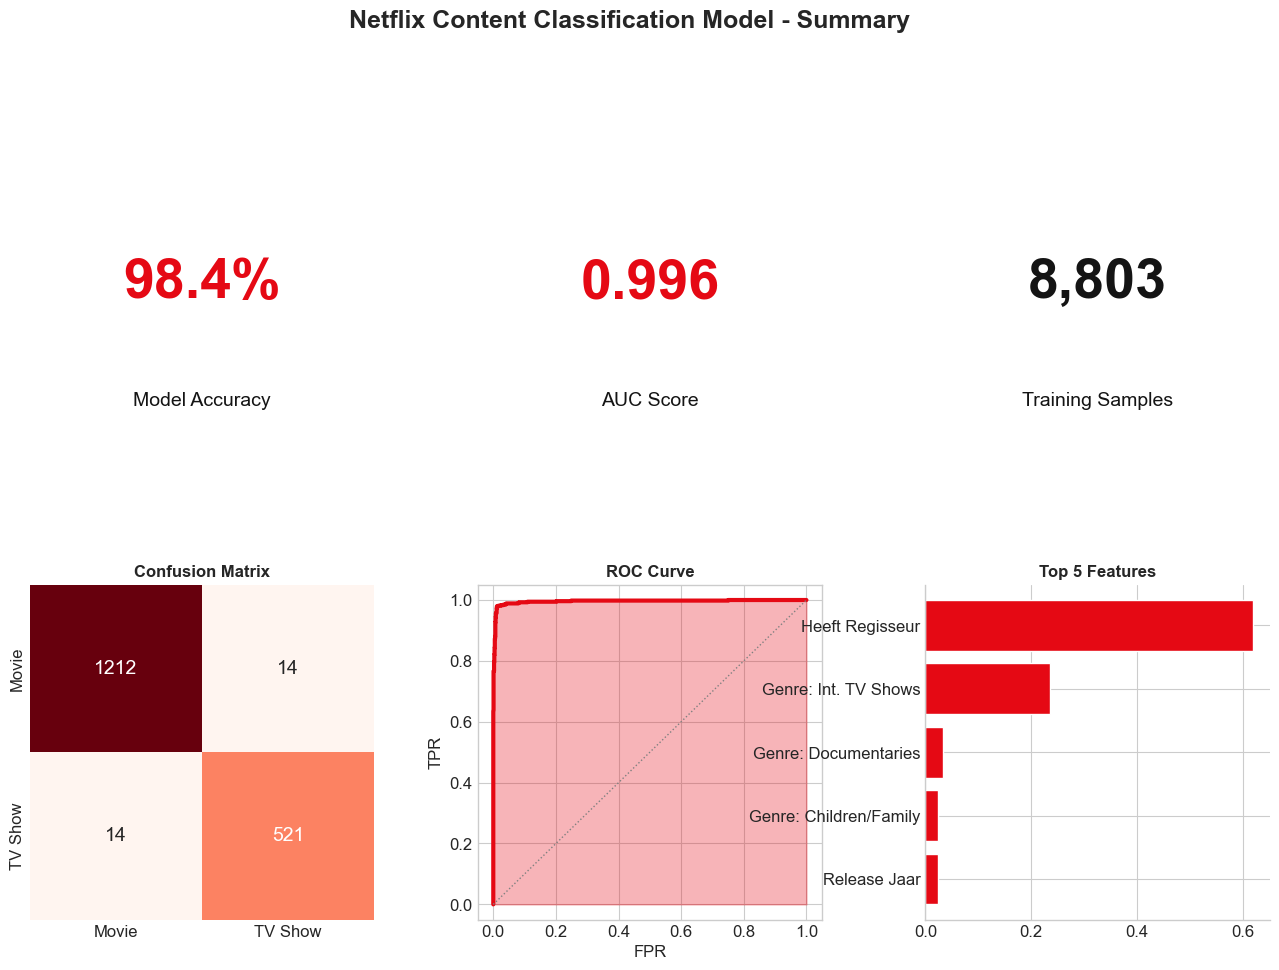

In [15]:
# Final Summary Dashboard
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Accuracy KPI
ax1 = fig.add_subplot(gs[0, 0])
accuracy = accuracy_score(y_test, y_pred_rf)
ax1.text(0.5, 0.6, f'{accuracy*100:.1f}%', fontsize=40, fontweight='bold', 
         ha='center', va='center', color=NETFLIX_RED)
ax1.text(0.5, 0.25, 'Model Accuracy', fontsize=14, ha='center', va='center', color=NETFLIX_BLACK)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.axis('off')
ax1.set_facecolor('#F5F5F5')

# AUC KPI
ax2 = fig.add_subplot(gs[0, 1])
ax2.text(0.5, 0.6, f'{roc_auc_rf:.3f}', fontsize=40, fontweight='bold', 
         ha='center', va='center', color=NETFLIX_RED)
ax2.text(0.5, 0.25, 'AUC Score', fontsize=14, ha='center', va='center', color=NETFLIX_BLACK)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')
ax2.set_facecolor('#F5F5F5')

# Samples KPI
ax3 = fig.add_subplot(gs[0, 2])
ax3.text(0.5, 0.6, f'{len(X):,}', fontsize=40, fontweight='bold', 
         ha='center', va='center', color=NETFLIX_BLACK)
ax3.text(0.5, 0.25, 'Training Samples', fontsize=14, ha='center', va='center', color=NETFLIX_BLACK)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.axis('off')
ax3.set_facecolor('#F5F5F5')

# Mini Confusion Matrix
ax4 = fig.add_subplot(gs[1, 0])
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds', ax=ax4,
            xticklabels=['Movie', 'TV Show'], yticklabels=['Movie', 'TV Show'],
            annot_kws={'size': 14}, cbar=False)
ax4.set_title('Confusion Matrix', fontsize=12, fontweight='bold')

# Mini ROC Curve
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(fpr_rf, tpr_rf, color=NETFLIX_RED, lw=3)
ax5.fill_between(fpr_rf, tpr_rf, alpha=0.3, color=NETFLIX_RED)
ax5.plot([0, 1], [0, 1], color='gray', lw=1, linestyle=':')
ax5.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax5.set_xlabel('FPR')
ax5.set_ylabel('TPR')

# Top Features
ax6 = fig.add_subplot(gs[1, 2])
top5_features = feature_importance.tail(5)
ax6.barh(top5_features['label'], top5_features['importance'], color=NETFLIX_RED, edgecolor='white')
ax6.set_title('Top 5 Features', fontsize=12, fontweight='bold')
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)

plt.suptitle('Netflix Content Classification Model - Summary', fontsize=18, fontweight='bold', y=1.02)

plt.savefig('model_05_summary_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [16]:
# Final Conclusions
print("\n" + "="*80)
print("MODEL CONCLUSIES")
print("="*80)

print("\n[1] MODEL PERFORMANCE")
print("-"*40)
print(f"   - Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)*100:.1f}%")
print(f"   - AUC Score: {roc_auc_rf:.3f}")
print(f"   - Het model kan Movies en TV Shows goed onderscheiden!")

print("\n[2] BELANGRIJKSTE ONDERSCHEIDENDE KENMERKEN")
print("-"*40)
print("   Top 3 features die Movies vs TV Shows onderscheiden:")
for i, row in feature_importance.tail(3).iloc[::-1].iterrows():
    print(f"   - {row['label']}")

print("\n[3] KEY INSIGHTS")
print("-"*40)
print("   - Het 'International TV Shows' genre is de sterkste indicator")
print("   - Movies hebben vaker een regisseur in de metadata")
print("   - TV Shows hebben gemiddeld meer genres toegewezen")
print("   - Release jaar speelt een rol: meer recente content = meer TV Shows")

print("\n[4] BUSINESS IMPLICATIES")
print("-"*40)
print("   - Netflix categoriseert content voorspelbaar op basis van kenmerken")
print("   - Internationale content is sterker vertegenwoordigd bij TV Shows")
print("   - De trend verschuift naar meer TV Show productie")

print("\n" + "="*80)
print("GEGENEREERDE MODEL VISUALISATIES")
print("="*80)
model_visuals = [
    'model_01_confusion_matrix.png',
    'model_02_roc_curve.png',
    'model_03_feature_importance.png',
    'model_04_feature_analysis.png',
    'model_05_summary_dashboard.png'
]
for v in model_visuals:
    print(f"   - {v}")


MODEL CONCLUSIES

[1] MODEL PERFORMANCE
----------------------------------------
   - Random Forest Accuracy: 98.4%
   - AUC Score: 0.996
   - Het model kan Movies en TV Shows goed onderscheiden!

[2] BELANGRIJKSTE ONDERSCHEIDENDE KENMERKEN
----------------------------------------
   Top 3 features die Movies vs TV Shows onderscheiden:
   - Heeft Regisseur
   - Genre: Int. TV Shows
   - Genre: Documentaries

[3] KEY INSIGHTS
----------------------------------------
   - Het 'International TV Shows' genre is de sterkste indicator
   - Movies hebben vaker een regisseur in de metadata
   - TV Shows hebben gemiddeld meer genres toegewezen
   - Release jaar speelt een rol: meer recente content = meer TV Shows

[4] BUSINESS IMPLICATIES
----------------------------------------
   - Netflix categoriseert content voorspelbaar op basis van kenmerken
   - Internationale content is sterker vertegenwoordigd bij TV Shows
   - De trend verschuift naar meer TV Show productie

GEGENEREERDE MODEL VISUA